In [2]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.11.0
0.11.0
cpu


In [3]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

In [39]:
# tacotron2

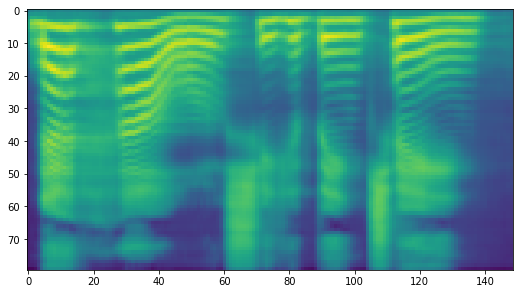

In [4]:
text = "ni hao, wo shi hu bing cheng"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)


plt.imshow(spec[0].cpu().detach())

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /home/bh2283/.cache/torch/hub/torchhub.zip
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/model.py:55: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torc

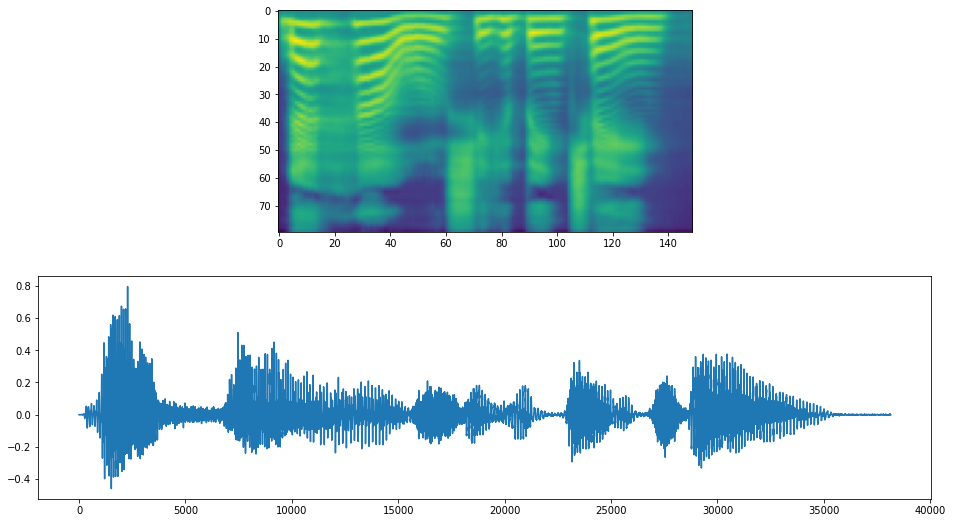

In [5]:
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach())
ax2.plot(waveforms[0].cpu().detach())

torchaudio.save("_assets/my_output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=22050)

# 初步训练/单说话人少量句子

In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
from utils.dataset import AiShell3PersonDataset, MelLoaderGenerator, RawLoaderGenerator

In [104]:
from pypinyin import lazy_pinyin

In [105]:
from torchaudio.pipelines._tts.utils import _get_chars
labels = _get_chars() + ('1', '2', '3', '4', '5')

In [106]:
labels[0]

'_'

In [270]:
def raw_audio_transform(sample, sample_rate=None):
        audio = sample['audio']
        audio = audio / torch.abs(audio).max()*0.15
        audio = torchaudio.functional.vad(audio, sample_rate, trigger_level=5)
        text = sample['text']
        text = text.split(' ')
        pinyin = [text[i] for i in range(len(text)) if i%2==1]
        pinyin = labels[0].join(pinyin)
        chinese = [text[i] for i in range(len(text)) if i%2==0]
        return {'audio':audio,
                'text': pinyin,
                'chinese': chinese}
sample_rate = 16000               
dataset = AiShell3PersonDataset('/scratch/bh2283/data/data_aishell3/train/', transform=raw_audio_transform, \
        person_id='SSB0011', sample_rate=sample_rate)
torchaudio.save('_assets/temp.wav', dataset[0]['audio'], sample_rate)
dataset[0]

{'audio': tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.6321e-05, 4.1846e-05,
          6.0390e-05]]),
 'text': 'yi2_wei4_gang2_gu3_fen1_xi1_shi1_biao3_shi4',
 'chinese': ['一', '位', '港', '股', '分', '析', '师', '表', '示']}

In [271]:
loaderGenerator = RawLoaderGenerator(labels, k_size=5)
loaderGenerator.version

'0.02'

In [272]:
train_set, test_set = dataset.split([1,0])

In [273]:
len(train_set), len(test_set)

(460, 0)

In [274]:
train_loader = loaderGenerator.dataloader(train_set, batch_size=8)

测试随机提取几组数据

In [275]:
steps = 3
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break
    print(sample_batched['audio'].shape, sample_batched['target'].shape)
    steps -= 1

torch.Size([8, 89644]) torch.Size([8, 114])
torch.Size([8, 103724]) torch.Size([8, 109])
torch.Size([8, 76703]) torch.Size([8, 90])


测试sort后是否顺序正常，听一下音频和文字是否相符

In [276]:
steps = 1
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break
    # sample_batched['audio'][0]
    torchaudio.save('_assets/temp.wav', sample_batched['audio'][0].unsqueeze(0), sample_rate)
    print(loaderGenerator.id2label(sample_batched['target'][0]))
    print(sample_batched['target_len'])
    steps -= 1

yao1_san1_si4_lu4_wu2_ren2_shou4_piao4_zhong1_guo2_tao2_ci2_cheng2_zhan4
tensor([72, 68, 60, 57, 54, 50, 42, 29])


数据绘制mel

In [277]:
mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,\
            n_fft=1024,power=1,hop_length=256,win_length=1024, n_mels=80, \
                f_min=0.0, f_max=8000.0, mel_scale="slaney", norm="slaney")
safe_log = lambda x: torch.log(x+2**(-15))

tensor(0.1500)


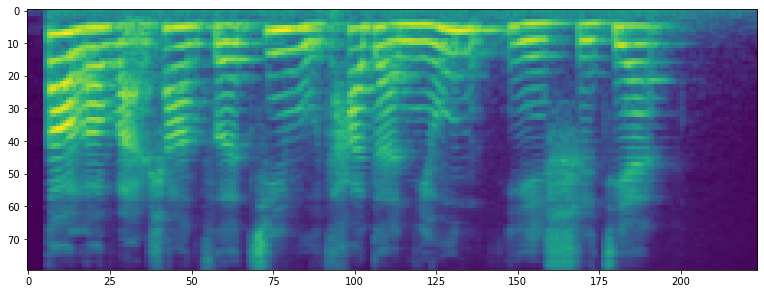

In [278]:
audio_test = dataset[212]['audio'][0]
print(torch.abs(audio_test).max())
# audio_test = audio_test / torch.abs(audio_test).max()*0.15
# audio_test = torchaudio.functional.vad(audio_test, sample_rate, trigger_level=5)
mel_test = safe_log(mel_transform(audio_test))
plt.imshow(mel_test)

In [279]:
my_tacotron2 = bundle.get_tacotron2()

In [280]:
from torch.nn.utils.rnn import pad_sequence

In [281]:
new_embedding = torch.nn.Embedding(len(labels), tacotron2.embedding.embedding_dim)

In [282]:
new_embedding.weight[:tacotron2.embedding.num_embeddings, :].shape

torch.Size([38, 512])

In [283]:
tacotron2.embedding.weight.shape

torch.Size([38, 512])

In [284]:
new_embedding.weight[:tacotron2.embedding.num_embeddings, :].data=tacotron2.embedding.weight.data

In [285]:
my_tacotron2.embedding=new_embedding

audio torch.Size([8, 69107]) target torch.Size([8, 90])
mel torch.Size([270, 80])
mel_length tensor([270, 259, 247, 222, 219, 241, 193, 189])
mels torch.Size([8, 80, 270])
output torch.Size([8, 80, 270]) torch.Size([8, 80, 270]) torch.Size([8, 270]) torch.Size([8, 270, 90])


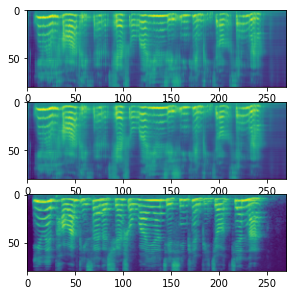

In [289]:
steps = 1
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break
    print('audio', sample_batched['audio'].shape, 'target', sample_batched['target'].shape)
    audio = sample_batched['audio']
    tokens = sample_batched['target']
    audio_len = sample_batched['audio_len']
    tokens_len = sample_batched['target_len']
    # print(tokens.shape)
    # print(audio[1][:audio_len[1]].shape)
    # break
    mels_list = [safe_log(mel_transform(audio[i][:audio_len[i]])).transpose(0,1) for i in range(len(audio_len))]
    steps -= 1
    print('mel', mels_list[0].shape)
    mel_length = torch.tensor([mel.shape[-2] for mel in mels_list])
    print('mel_length', mel_length)
    max_audio_length = torch.max(mel_length)
    mels_tensor = pad_sequence(mels_list, batch_first=True, padding_value=0.0).permute(0,2,1)
    print('mels', mels_tensor.shape)
    org_mel, pos_mel, stop_token, attentions = my_tacotron2.forward(tokens, tokens_len, mels_tensor, mel_length)
    print('output',org_mel.shape, pos_mel.shape, stop_token.shape, attentions.shape)
    fig, axs = plt.subplots(3)
    axs[0].imshow(org_mel[0].detach().numpy())
    axs[1].imshow(pos_mel[0].detach().numpy())
    axs[2].imshow(mels_tensor[0][:, :mel_length[0]].detach().numpy())